# 写経
https://www.kaggle.com/carlolepelaars/pubg-data-exploration-rf-funny-gifs

In [55]:
#標準的なライブラリ
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))

#可視化のライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
from pdpbox import pdp
from plotnine import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

#機械学習
import sklearn
from scipy.cluster import hierarchy as hc
from fastai.imports import *

#
%load_ext autoreload
%autoreload 2
%matplotlib inline


['train_V2.csv', 'test_V2.csv', 'sample_submission_V2.csv']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
train = pd.read_csv('../input/train_V2.csv')
test = pd.read_csv('../input/test_V2.csv')

In [3]:
display(train.head())

display(train.tail())

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00,0,0,0,74,1029,0,0,0.00,1873,squad-fpp,29,28,-1,0,1292.0,0,0.000,0,0,1019.0,3,1507,0.1786
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15,0,0,0,69,0,0,0,0.00,1435,solo,93,93,1501,0,0.0,0,0.000,0,0,81.7,6,0,0.2935
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06,0,0,0,66,0,0,0,0.00,1321,squad-fpp,28,28,1500,0,0.0,0,2.184,0,0,788.7,4,0,0.4815
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.40,1,1,2,11,0,2,1,98.50,1373,squad-fpp,26,25,1418,2,0.0,0,0.000,0,0,2748.0,8,0,0.8000
4446965,0d8e7ed728b6fd,8c74f72fedf5ff,62a16aabcc095c,0,2,268.00,0,0,1,18,0,2,1,78.25,1766,solo-fpp,98,94,1590,0,1369.0,0,0.000,0,0,1244.0,5,0,0.5464


# 教師データの統計的集計

In [4]:
train.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446965e+06
mean,2.338149e-01,1.106908e+00,1.307171e+02,6.578755e-01,2.268196e-01,1.370147e+00,4.759935e+01,5.050060e+02,9.247833e-01,5.439551e-01,2.299759e+01,1.579506e+03,4.450467e+01,4.300759e+01,8.920105e+02,1.646590e-01,6.061157e+02,3.496091e-03,4.509322e+00,2.386841e-02,7.918208e-03,1.154218e+03,3.660488e+00,6.064601e+02,4.728216e-01
std,5.885731e-01,1.715794e+00,1.707806e+02,1.145743e+00,6.021553e-01,2.679982e+00,2.746294e+01,6.275049e+02,1.558445e+00,7.109721e-01,5.097262e+01,2.587399e+02,2.382811e+01,2.328949e+01,7.366478e+02,4.721671e-01,1.498344e+03,7.337297e-02,3.050220e+01,1.673935e-01,9.261157e-02,1.183497e+03,2.456544e+00,7.397004e+02,3.074050e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.367000e+03,2.800000e+01,2.700000e+01,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.551000e+02,2.000000e+00,0.000000e+00,2.000000e-01
50%,0.000000e+00,0.000000e+00,8.424000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.438000e+03,3.000000e+01,3.000000e+01,1.443000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.856000e+02,3.000000e+00,0.000000e+00,4.583000e-01
75%,0.000000e+00,2.000000e+00,1.860000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,2.132000e+01,1.851000e+03,4.900000e+01,4.700000e+01,1.500000e+03,0.000000e+00,1.909750e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,5.000000e+00,1.495000e+03,7.407000e-01
max,2.200000e+01,3.300000e+01,6.616000e+03,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,1.094000e+03,2.237000e+03,1.000000e+02,1.000000e+02,5.910000e+03,3.900000e+01,4.071000e+04,1.800000e+01,3.823000e+03,1.200000e+01,5.000000e+00,2.578000e+04,2.360000e+02,2.013000e+03,1.000000e+00


# 型、メモリ使用量、たてよこ、など

In [5]:
train.info()

print('the shape is : ', train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB
the shape is :  (4446966, 29)


DBNOs...倒した敵の数  
assists...自分がダメージを与えていて、味方が倒した敵の数  
boosts...使用したブースとアイテムの数  
damageDealt...与えたダメージの総量  
...  
winPlacePerc...予測の対象。1が1位、0が最下位


# 不正なマッチ

In [6]:
train[train['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,0,0,0,0.0,9,solo-fpp,1,1,1574,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [7]:
#削除
train.drop(2744604, inplace=True)

In [8]:
train[train['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc


# 特徴エンジニアリング

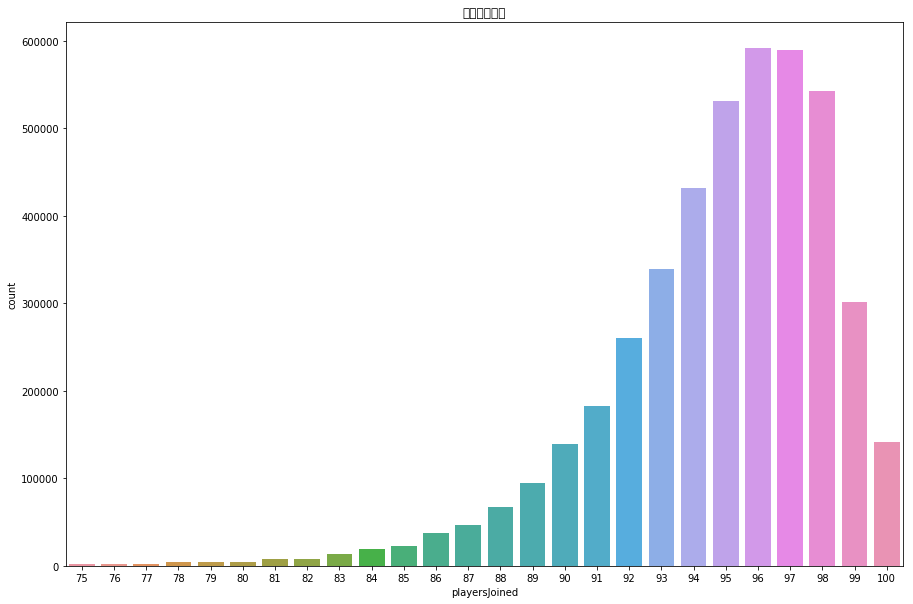

In [9]:
#プレイヤー数
train['playersJoined'] = train.groupby('matchId')['matchId'].transform('count')
plt.figure(figsize=(15,10))
sns.countplot(train[train['playersJoined']>=75]['playersJoined'])
plt.title('プレイヤー数')
plt.show()

## 標準化

In [10]:
#既存の関数で標準化するのかと思ったら違った
train['killsNorm'] = train['kills']*((100-train['playersJoined'])/100 +1)
train['damageDealtNorm'] = train['damageDealt']*((100-train['playersJoined'])/100 +1)
train['maxPlaceNorm'] = train['maxPlace']*((100-train['playersJoined'])/100 +1)
train['matchDurationNorm'] = train['matchDuration']*((100-train['playersJoined'])/100 +1)

#出力して確認
to_show = ['Id', 'kills', 'killsNorm', 'damageDealt', 'damageDealtNorm', 'maxPlace',
           'maxPlaceNorm', 'matchDuration', 'matchDurationNorm']
train[to_show][0:20]

,Id,kills,killsNorm,damageDealt,damageDealtNorm,maxPlace,maxPlaceNorm,matchDuration,matchDurationNorm
0,7f96b2f878858a,0,0.00,0.000,0.00000,28,29.12,1306,1358.24
1,eef90569b9d03c,0,0.00,91.470,99.70230,26,28.34,1777,1936.93
2,1eaf90ac73de72,0,0.00,68.000,69.36000,50,51.00,1318,1344.36
3,4616d365dd2853,0,0.00,32.900,35.86100,31,33.79,1436,1565.24
4,315c96c26c9aac,1,1.03,100.000,103.00000,97,99.91,1424,1466.72
5,ff79c12f326506,1,1.05,100.000,105.00000,28,29.40,1395,1464.75
6,95959be0e21ca3,0,0.00,0.000,0.00000,28,28.84,1316,1355.48
7,311b84c6ff4390,0,0.00,8.538,8.87952,96,99.84,1967,2045.68
8,1a68204ccf9891,0,0.00,51.600,53.14800,28,28.84,1375,1416.25
9,e5bb5a43587253,0,0.00,37.270,38.38810,29,29.87,1930,1987.90


## ヒール+ブースト
必要かどうかはわかんないけど、いつでも消せるし、それはランダムフォレストが教えてくれる

In [11]:
train['healsandboosts'] = train['heals'] + train['boosts']
to_show = ['heals', 'boosts', 'healsandboosts']
train[to_show].tail()

,heals,boosts,healsandboosts
4446961,0,0,0
4446962,0,1,1
4446963,0,0,0
4446964,2,4,6
4446965,1,2,3


## 動かずに倒している人
チーターを見つける

In [12]:
#総移動距離
train['totalDistance'] = train['rideDistance'] + train['walkDistance'] + train['swimDistance']

#動かずに倒したフラグ
train['killsWithoutMoving'] = ((train['kills'] > 0) & (train['totalDistance'] == 0))

## 外れ値検出　Outlier Detection

In [13]:
train['killsWithoutMoving'].value_counts()

False    4445430
True        1535
Name: killsWithoutMoving, dtype: int64

In [14]:
#削除
train.drop(train[train['killsWithoutMoving'] == True].index, inplace=True)

## ひき殺した数(roadKills)の中の異常

In [15]:
train[train['roadKills'] > 10]#.shape

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving
2733926,c3e444f7d1289f,489dd6d1f2b3bb,4797482205aaa4,0,0,1246.0,0,0,0,1,1403,14,13,7.181,1456,solo,92,80,-1,0,0.005,14,5.297,0,0,1277.0,0,1371,0.4286,92,15.12,1345.68,99.36,1572.48,0,1282.302,False
2767999,34193085975338,bd7d50fa305700,a22354d036b3d6,0,0,1102.0,0,0,0,1,1497,11,11,0.000,1946,solo,88,77,-1,0,4118.000,11,0.000,0,0,816.6,5,1533,0.4713,88,12.32,1234.24,98.56,2179.52,0,4934.600,False
2890740,a3438934e3e535,1081c315a80d14,fe744430ac0070,0,8,2074.0,0,1,11,1,1114,20,18,64.290,1970,solo,38,20,-1,0,2726.000,18,0.000,0,0,3150.0,4,1568,1.0000,38,32.40,3359.88,61.56,3191.40,19,5876.000,False
3524413,9d9d044f81de72,8be97e1ba792e3,859e2c2db5b125,0,3,1866.0,0,5,7,1,1520,18,11,341.400,1925,solo,84,70,-1,0,6812.000,11,0.000,0,0,1041.0,10,1606,0.9398,84,20.88,2164.56,97.44,2233.00,10,7853.000,False


## 命中の異常

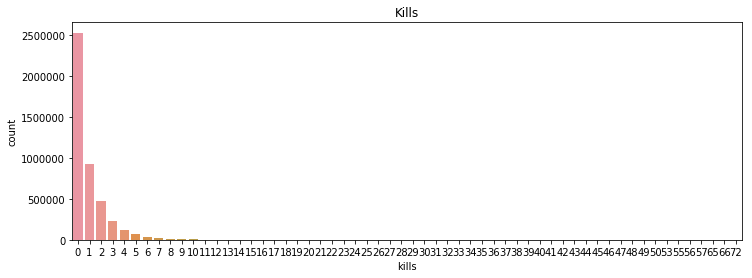

In [16]:
plt.figure(figsize=(12, 4))
sns.countplot(data=train, x=train['kills']).set_title('Kills')
plt.show()

In [17]:
display(train[train['kills'] > 30].shape)
train[train['kills'] > 30].head(10)

(95, 37)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving
57978,9d8253e21ccbbd,ef7135ed856cd8,37f05e2a01015f,9,0,3725.0,0,7,0,2,1000,35,3,105.80,1798,normal-duo-fpp,8,7,-1,0,0.0,0,0.0,0,0,48.82,48,1500,0.8571,16,64.40,6854.00,14.72,3308.32,0,48.82,False
87793,45f76442384931,b3627758941d34,37f05e2a01015f,8,0,3087.0,0,8,27,3,1000,31,3,95.34,1798,normal-duo-fpp,8,7,-1,0,0.0,0,0.0,0,0,780.70,45,1500,1.0000,16,57.04,5680.08,14.72,3308.32,27,780.70,False
156599,746aa7eabf7c86,5723e7d8250da3,f900de1ec39fa5,21,0,5479.0,0,12,7,4,0,48,6,81.95,1798,normal-solo-fpp,11,11,1500,0,0.0,0,0.0,0,0,23.71,61,0,0.7000,11,90.72,10355.31,20.79,3398.22,7,23.71,False
160254,15622257cb44e2,1a513eeecfe724,db413c7c48292c,1,0,4033.0,0,40,0,1,1000,42,5,266.20,844,normal-squad-fpp,8,8,-1,0,0.0,0,0.0,1,0,718.30,16,1500,1.0000,62,57.96,5565.54,11.04,1164.72,0,718.30,False
180189,1355613d43e2d0,f863cd38c61dbf,39c442628f5df5,5,0,3171.0,0,6,15,1,0,35,3,102.50,1796,normal-solo-fpp,9,6,1500,0,0.0,0,0.0,0,0,71.51,41,0,1.0000,11,66.15,5993.19,17.01,3394.44,15,71.51,False
334400,810f2379261545,7f3e493ee71534,f900de1ec39fa5,20,0,6616.0,0,13,5,1,0,65,7,73.90,1798,normal-solo-fpp,11,11,1500,0,0.0,0,0.0,0,0,1036.00,60,0,1.0000,11,122.85,12504.24,20.79,3398.22,5,1036.00,False
353128,f3e9746e3ff151,4bc1f00f07b304,a9e84c456cc859,2,0,3834.0,0,9,5,1,0,39,3,263.90,1795,normal-solo-fpp,13,10,1500,0,0.0,0,0.0,0,0,124.20,42,0,1.0000,13,72.93,7169.58,24.31,3356.65,5,124.20,False
457829,265e23756baa0b,9d94424171c2a1,664dee9ed8f646,3,0,2907.0,0,27,2,1,0,33,4,439.20,827,normal-squad,5,5,1500,0,0.0,0,0.0,1,0,382.40,15,0,1.0000,38,53.46,4709.34,8.10,1339.74,2,382.40,False
488335,31a0682922ef45,275a27a3ee4cc8,3037f74ef8a3a3,2,0,3055.0,0,9,0,1,1000,33,5,97.99,892,normal-solo-fpp,18,14,-1,0,0.0,0,0.0,0,0,35.30,31,1500,1.0000,20,59.40,5499.00,32.40,1605.60,0,35.30,False
662650,dd424a8b74bd49,ac9dea6d62f2e6,8a728def0644be,9,0,3454.0,38,9,4,1,1000,34,4,124.00,1198,normal-squad-fpp,14,14,-1,0,0.0,0,0.0,0,0,111.10,25,1500,0.2308,54,49.64,5042.84,20.44,1749.08,4,111.10,False


In [18]:
train.drop(train[train['kills'] > 30].index, inplace=True)

## 命中の異常値　その2(100% ヘッドショット)

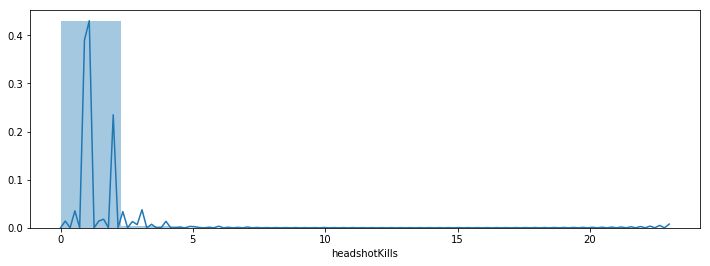

In [20]:
plt.figure(figsize=(12, 4))
sns.distplot(train['headshotKills'], bins=10)
plt.show()

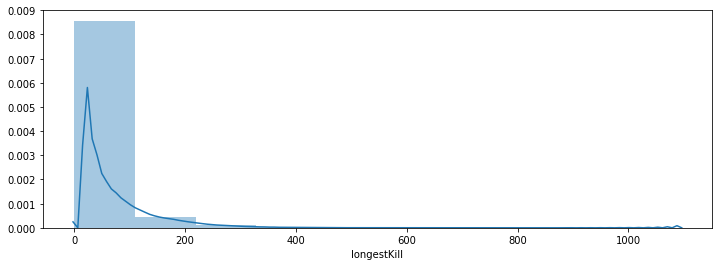

In [21]:
plt.figure(figsize=(12, 4))
sns.distplot(train['longestKill'], bins=10)
plt.show()

In [22]:
display(train[train['longestKill'] > 1000].shape)
train[train['longestKill'] >= 1000].head()

(18, 37)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving
202281,88e2af7d78af5a,34ddeede52c042,4346bc63bc67fa,0,3,783.9,5,1,1,5,0,4,3,1000.0,1864,squad,27,27,1482,0,723.2,0,0.0,0,1,3052.00,9,0,0.9231,88,4.48,877.968,30.24,2087.68,4,3775.20,False
240005,41c2f5c0699807,9faecf87ab4275,634edab75860b3,5,0,1284.0,8,5,7,18,1000,11,2,1004.0,1308,normal-duo-fpp,14,13,-1,1,0.0,0,0.0,0,0,48.87,38,1500,0.5385,29,18.81,2195.640,23.94,2236.68,7,48.87,False
324313,ef390c152bcc3d,30fd444be3bbc1,4f7f8d6cf558b4,2,0,1028.0,0,0,0,9,0,10,2,1026.0,698,normal-squad-fpp,13,13,1500,0,1717.0,0,0.0,0,0,1264.00,26,0,1.0000,51,14.90,1531.720,19.37,1040.02,0,2981.00,False
656553,9948b058562163,c8cb8491112bf6,0104eeb664494d,6,0,1410.0,17,5,0,3,1000,16,4,1000.0,1091,normal-squad-fpp,6,6,-1,4,0.0,0,0.0,0,0,29.21,30,1500,0.6000,41,25.44,2241.900,9.54,1734.69,0,29.21,False
803632,4e7e6c74e3c57d,94698690918933,da91b0c3d875f8,0,0,196.8,0,0,0,51,0,1,1,1075.0,471,normal-squad-fpp,8,8,1500,0,2085.0,0,0.0,0,0,1074.00,22,0,0.0000,61,1.39,273.552,11.12,654.69,0,3159.00,False


## 移動距離の異常

In [23]:
train[['walkDistance', 'rideDistance', 'swimDistance', 'totalDistance']].describe()

,walkDistance,rideDistance,swimDistance,totalDistance
count,4.445335e+06,4.445335e+06,4.445335e+06,4.445335e+06
mean,1.154628e+03,6.063298e+02,4.510974e+00,1.765469e+03
std,1.183513e+03,1.498570e+03,3.050767e+01,2.183258e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.554000e+02,0.000000e+00,0.000000e+00,1.584000e+02
50%,6.864000e+02,0.000000e+00,0.000000e+00,7.893000e+02
75%,1.977000e+03,2.612500e-01,0.000000e+00,2.729000e+03
max,2.578000e+04,4.071000e+04,3.823000e+03,4.127010e+04


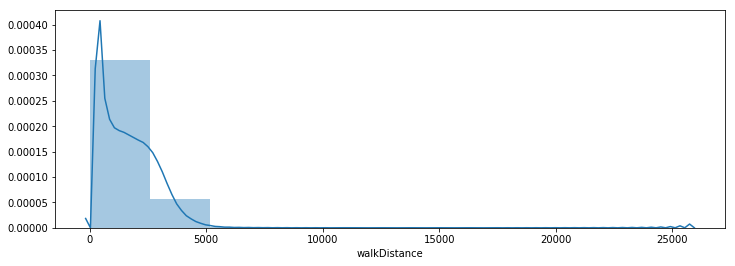

In [24]:
plt.figure(figsize=(12, 4))
sns.distplot(train['walkDistance'], bins=10)
plt.show()

In [25]:
display(train[train['walkDistance'] >= 10000].shape)
train[train['walkDistance'] > 10000].head()

(219, 37)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving
23026,8a6562381dd83f,23e638cd6eaf77,b0a804a610e9b0,0,1,0.00,0,0,0,44,0,0,0,0.000,1906,solo,99,93,1517,0,0.4212,0,9.882,0,0,13530.0,7,0,0.8163,99,0.00,0.0000,99.99,1925.06,1,13540.3032,False
34344,5a591ecc957393,6717370b51c247,a15d93e7165b05,0,3,23.22,0,0,1,34,1256,0,0,0.000,1977,squad-fpp,20,20,-1,0,0.0373,0,40.870,0,0,10030.0,7,1533,0.9474,65,0.00,31.3470,27.00,2668.95,4,10070.9073,False
49312,582685f487f0b4,338112cd12f1e7,d0afbf5c3a6dc9,0,4,117.20,1,0,1,24,0,1,1,6.823,2192,duo-fpp,47,46,1507,0,0.0088,0,36.750,0,0,12410.0,3,0,0.9130,94,1.06,124.2320,49.82,2323.52,5,12446.7588,False
68590,8c0d9dd0b4463c,c963553dc937e9,926681ea721a47,0,1,32.34,0,0,1,46,1378,0,0,0.000,1836,duo-fpp,49,47,-1,0,847.8000,0,45.820,0,0,11590.0,3,1563,0.8333,96,0.00,33.6336,50.96,1909.44,2,12483.6200,False
94400,d441bebd01db61,7e179b3366adb8,923b57b8b834cc,1,1,73.08,0,0,3,27,1000,0,0,0.000,1806,solo,73,64,-1,0,1005.0000,0,45.630,0,0,10440.0,6,1488,0.8194,73,0.00,92.8116,92.71,2293.62,4,11490.6300,False


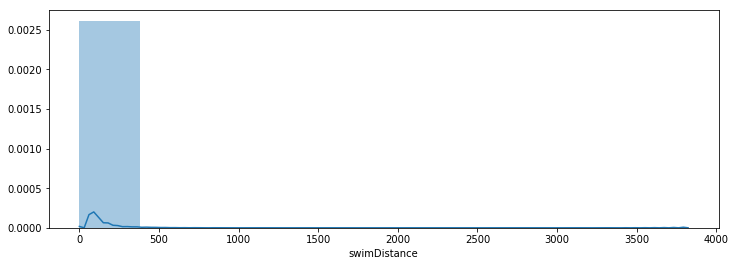

In [26]:
plt.figure(figsize=(12, 4))
sns.distplot(train['swimDistance'], bins=10)
plt.show()

In [27]:
# Players who swam more than 2 km
train[train['swimDistance'] >= 2000]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving
177973,c2e9e5631f4e54,23213058f83abe,f01eb1073ef377,0,5,78.12,1,0,1,47,1058,0,0,0.00,1399,duo-fpp,50,46,-1,0,0.0,0,2295.0,0,0,1002.000,4,1466,0.9592,98,0.00,79.6824,51.00,1426.98,6,3297.000,False
274258,ba5e3dfb5a0fa0,383db055216ec2,d6e13468e28ab4,0,4,53.32,0,0,16,39,0,0,0,0.00,2188,squad,26,25,1584,0,5689.0,0,2148.0,0,0,2276.000,5,0,0.9600,94,0.00,56.5192,27.56,2319.28,20,10113.000,False
1005337,d50c9d0e65fe2a,4996575c11abcb,668402592429f8,0,1,503.00,4,3,1,6,1103,3,1,868.70,1897,squad,26,25,-1,0,3331.0,0,2718.0,0,0,4691.000,5,1516,1.0000,88,3.36,563.3600,29.12,2124.64,2,10740.000,False
1195818,f811de9de80b70,d08ddf7beb6252,8a48703ab52ec8,0,7,352.30,3,1,6,4,1039,5,1,64.48,1396,duo-fpp,49,48,-1,0,0.0,0,2668.0,0,0,415.100,10,1499,1.0000,98,5.10,359.3460,49.98,1423.92,13,3083.100,False
1227362,a33e917875c80e,5b72674b42712b,5fb0d8b1fc16cf,0,1,589.20,3,1,1,46,0,2,1,48.21,1021,normal-squad-fpp,12,12,1500,0,0.0,0,3823.0,0,0,995.300,9,0,1.0000,86,2.28,671.6880,13.68,1163.94,2,4818.300,False
1889163,bd8cc3083a9923,1d5d17140d6fa4,8e2e6022d6e5c8,0,0,0.00,0,0,0,47,0,0,0,0.00,1387,squad-fpp,25,23,1327,0,864.0,0,2484.0,0,0,1966.000,3,0,0.5833,87,0.00,0.0000,28.25,1567.31,0,5314.000,False
2065940,312ccbb27b99aa,47c7f4d69e2fb1,b4b11756321f3a,1,3,49.59,0,0,5,48,1097,0,0,0.00,1379,duo-fpp,48,46,0,1,2089.0,0,3514.0,0,0,4296.000,8,1492,0.8511,96,0.00,51.5736,49.92,1434.16,8,9899.000,False
2327586,8773d0687c6aae,b17f46f9f6666c,56ee5897512c86,3,1,474.40,2,0,0,7,0,3,2,30.02,1210,squad-fpp,27,24,1516,0,0.0,0,2387.0,0,0,7.546,6,0,1.0000,91,3.27,517.0960,29.43,1318.90,1,2394.546,False
2784855,a8653b87e83892,383db055216ec2,d6e13468e28ab4,1,4,843.80,5,5,2,2,0,7,1,696.80,2188,squad,26,25,1628,1,3033.0,0,2206.0,0,0,4687.000,4,0,0.9600,94,7.42,894.4280,27.56,2319.28,6,9926.000,False
3359439,3713b36e1ba9e1,1f7aed9240864a,584447ed875c85,0,0,0.00,0,0,0,77,1056,0,0,0.00,1372,squad-fpp,29,29,-1,0,0.0,0,2338.0,0,0,1750.000,0,1518,0.2143,96,0.00,0.0000,30.16,1426.88,0,4088.000,False


略

# カテゴリ値
ワンホットエンコード

In [28]:
train['matchType'].nunique()

16

In [29]:
#ワンホットエンコード
train = pd.get_dummies(train, columns=['matchType'])

#正規表現で抜き出し
matchType_encoding = train.filter(regex='matchType')

matchType_encoding.head()

,matchType_crashfpp,matchType_crashtpp,matchType_duo,matchType_duo-fpp,matchType_flarefpp,matchType_flaretpp,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [30]:
#groupIdとmatchIdをカテゴリー値に変換

train['groupId'] = train['groupId'].astype('category')
train['matchId'] = train['matchId'].astype('category')

train['groupId_cat'] = train['groupId'].cat.codes
train['matchId_cat'] = train['matchId'].cat.codes

train.drop(columns=['groupId', 'matchId'], inplace=True)

train[['groupId_cat', 'matchId_cat']].head()

,groupId_cat,matchId_cat
0,613675,30085
1,827694,32751
2,843387,3143
3,1340251,45260
4,1757584,20531


# 機械学習の準備

## サンプリング

In [31]:
sample = 500000
df_sample = train.sample(sample)

## 目的変数と検証データを分ける

In [32]:
df = df_sample.drop(columns = ['winPlacePerc'])
y = df_sample['winPlacePerc']

In [33]:
def split_vals(a, n : int):
    return a[:n].copy(), a[n:].copy()

val_perc = 0.12 #検証に使う分
n_valid = int(val_perc * sample)
n_trn = len(df)-n_valid

raw_train, raw_valid = split_vals(df_sample, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

print('Sample train shape: ', X_train.shape,
      'Sample target shape: ', y_train.shape,
      'Sample validation shape: ', X_valid.shape)

Sample train shape:  (440000, 51) Sample target shape:  (440000,) Sample validation shape:  (60000, 51)


In [46]:
#MAE mean absolute error 平均絶対誤差
from sklearn.metrics import mean_absolute_error

def print_score(m : RandomForestRegressor):
    res = ['mae train: ', mean_absolute_error(m.predict(X_train2), y_train),
           'mae val: ', mean_absolute_error(m.predict(X_valid2), y_valid)]
    
    if hasattr(m, 'oob_score_'):res.append(m.oob_score_)
    print(res)

## 最初の基本のランダムフォレストモデル

In [47]:
#IDが邪魔っぽい
X_train.columns
X_train['Id']
X_train2 = X_train.drop(['Id'], axis=1)
X_valid2 = X_valid.drop(['Id'], axis=1)
X_train2.shape
#y_train

(440000, 50)

In [48]:
m1 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features='sqrt', n_jobs=-1)
m1.fit(X_train2, y_train)
print_score(m1)

['mae train: ', 0.03911269181613046, 'mae val: ', 0.06252299311261013]


## 特徴の重要度

In [58]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

df = df.drop(['Id'], axis=1)
fi = rf_feat_importance(m1, df); fi[:10]

,cols,imp
21,walkDistance,0.312805
6,killPlace,0.161903
1,boosts,0.117649
30,totalDistance,0.113578
29,healsandboosts,0.057136
22,weaponsAcquired,0.052068
5,heals,0.028852
16,rideDistance,0.022636
2,damageDealt,0.013636
28,matchDurationNorm,0.012171


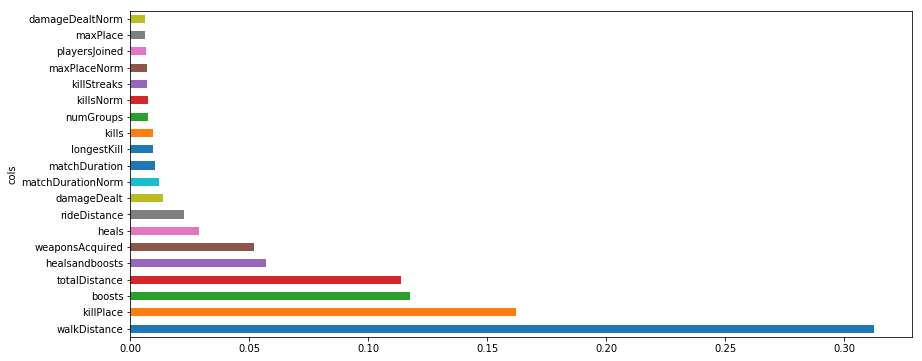

In [60]:
plot1 = fi[:20].plot('cols', 'imp', figsize=(14, 6), legend=False, kind='barh')
plot1

In [61]:
to_keep = fi[fi.imp>0.005].cols

#重要な特徴
print('Significant features: ', len(to_keep))
to_keep

Significant features:  20


21         walkDistance
6             killPlace
1                boosts
30        totalDistance
29       healsandboosts
22      weaponsAcquired
5                 heals
16         rideDistance
2           damageDealt
28    matchDurationNorm
11        matchDuration
10          longestKill
8                 kills
13            numGroups
25            killsNorm
9           killStreaks
27         maxPlaceNorm
24        playersJoined
12             maxPlace
26      damageDealtNorm
Name: cols, dtype: object

In [75]:
#重要な特徴量だけのデータフレームを作る
df_keep = df[to_keep].copy()
y_keep = y[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)
y_train, y_valid = split_vals(y_keep, n_trn)

In [76]:
X_train.shape

#X_train2 = X_train.drop(['Id'], axis=1)
#X_valid2 = X_valid.drop(['Id'], axis=1)

(440000, 20)

## 2回目のランダムフォレストモデル

In [80]:
#m1 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features='sqrt', n_jobs=-1)
m2 = RandomForestRegressor(n_estimators=80, min_samples_leaf=3, max_features='sqrt', n_jobs=-1)
m2.fit(X_train, y_train)
print_score(m2)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [79]:
fi_to_keep = rf_feat_importance(m2, df_keep)
plot2 = fi_to_keep.plot('cols', 'imp', figsize=(14, 6), legend=False, kind='barh')
plot2

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.